# Rolling window

# ==================

### Peaks
### Valleys
### Window size

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [77]:

def rolling_window(financial_data: pd.DataFrame, record_to_plot: int = None, order: int = 5, peak_coeff=0.7, valley_coeff=0.5, to_plot: bool = False):
    financial_data = financial_data[:record_to_plot]
    financial_data['signal'] = 0

    data = financial_data['Close'].to_numpy()

    def detect_local_valley(data, curr_index, order, coeff):
        # Check if the current index is within the bounds of the data array
        if curr_index < order or curr_index >= len(data) - order:
            # If not, return False because there are not enough values in the window to compare with the current value
            return False

        # Create a window of size 'order' around the current index by slicing the 'data' array
        window = data[curr_index - order:curr_index + order + 1]

        # Calculate the threshold value for detecting valleys by adding the minimum value of the window to the product of the range of the window and the 'coeff' argument
        threshold = np.min(window) + coeff * (np.max(window) - np.min(window))

        # Compare the value at the current index with the threshold value
        if data[curr_index] <= threshold:
            # If the value at the current index is less than or equal to the threshold value, return True to indicate that a local valley has been detected
            return True
        else:
            # Otherwise, return False to indicate that a local valley has not been detected
            return False

    def detect_local_peak(data, curr_index, order, coeff):

        if curr_index < order or curr_index >= len(data) - order:
            return False

        window = data[curr_index - order:curr_index + order + 1]
        threshold = coeff * (np.max(window) - np.min(window)) + np.min(window)

        # Function is the same as for valleys, but with the inequality reversed
        return data[curr_index] >= threshold

    # 2 List Comprehensions to find the indices of the peaks and valleys

    # - Peaks: The value at the current index is greater than or equal to the threshold value
    detected_peaks = [i for i in range(order, len(
        data) - order) if detect_local_peak(data, i, order, peak_coeff)]

    # - Valleys: The value at the current index is less than or equal to the threshold value
    detected_valleys = [i for i in range(order, len(
        data) - order) if detect_local_valley(data, i, order, valley_coeff)]

    idx = financial_data.index
    last_signal = 0

    # Loop through each index in the 'financial_data' DataFrame
    for i in range(len(financial_data)):
        # Set the 'signal' column value to 0 for the current index
        financial_data.loc[i, 'signal'] = 0

        # Check if the current index is a detected peak
        for peak in detected_peaks:
            if i == peak:
                # If the current index is a peak and the last signal was not a sell signal, plot a red scatter point at the current index and set the 'signal' column value to 1
                if last_signal != 1:
                    plt.scatter(idx[i], financial_data['Low'][i],
                                c='red', label='Sell', linewidth=1)
                    last_signal = 1
                    financial_data.loc[i, 'signal'] = 1

        # Check if the current index is a detected valley
        for valley in detected_valleys:
            if i == valley:
                # If the current index is a valley and the last signal was not a buy signal, plot a lime scatter point at the current index and set the 'signal' column value to 2
                if last_signal != 2:
                    plt.scatter(idx[i], financial_data['Low'][i],
                                c='lime', label='Buy', linewidth=1)
                    last_signal = 2
                    financial_data.loc[i, 'signal'] = 2

    if to_plot:
        plt.plot(idx, financial_data['Close'])
        plt.show()

    return financial_data


In [78]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [79]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

## Experiment with trying to find the best combination of coefficients for a rolling window

```
highest_score = {
    "Equity Final [$]": 0,
    "peak_coeff": 0,
    "valley_coeff": 0
    
}
for j in range(1,10):
    for i in range(1,10):
        financial_data = rolling_window(financial_data, record_to_plot=1000, peak_coeff=j/10, valley_coeff=i/10, to_plot=False)
        bt,stats = backtester(financial_data)
        if stats["Equity Final [$]"] > highest_score["Equity Final [$]"]:
            highest_score = stats
            highest_score["peak_coeff"] = j/10
            highest_score["valley_coeff"] = i/10
                
    print(highest_score)
    
```

highest_score = {
    "Equity Final [$]":  12141.7
    "peak_coeff": 0.6,
    "valley_coeff": 0.3
     }


C:\Users\bobek\AppData\Local\Temp\ipykernel_19412\3389575598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_data['signal'] = 0


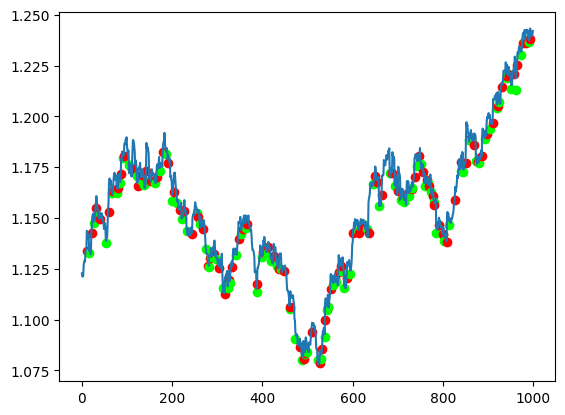

c:\Users\bobek\QuantWiseAI\jupiter_notebooks\apply_backtesting.py:34: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(financial_data, MyCandlesStrat, cash=10_000, commission=.00)


In [80]:
from apply_backtesting import backtester

financial_data = rolling_window(financial_data, record_to_plot=1000,peak_coeff=0.6, valley_coeff=0.3, to_plot=True)
bt,stats = backtester(financial_data)

In [81]:
#visualize the backtesting

import backtesting

# import output_notebook
from bokeh.io import output_notebook
output_notebook()

backtesting.set_bokeh_output(notebook=True)
bt.plot()

Loading BokehJS ...

Row(id='8531', ...)

12141.769300000002


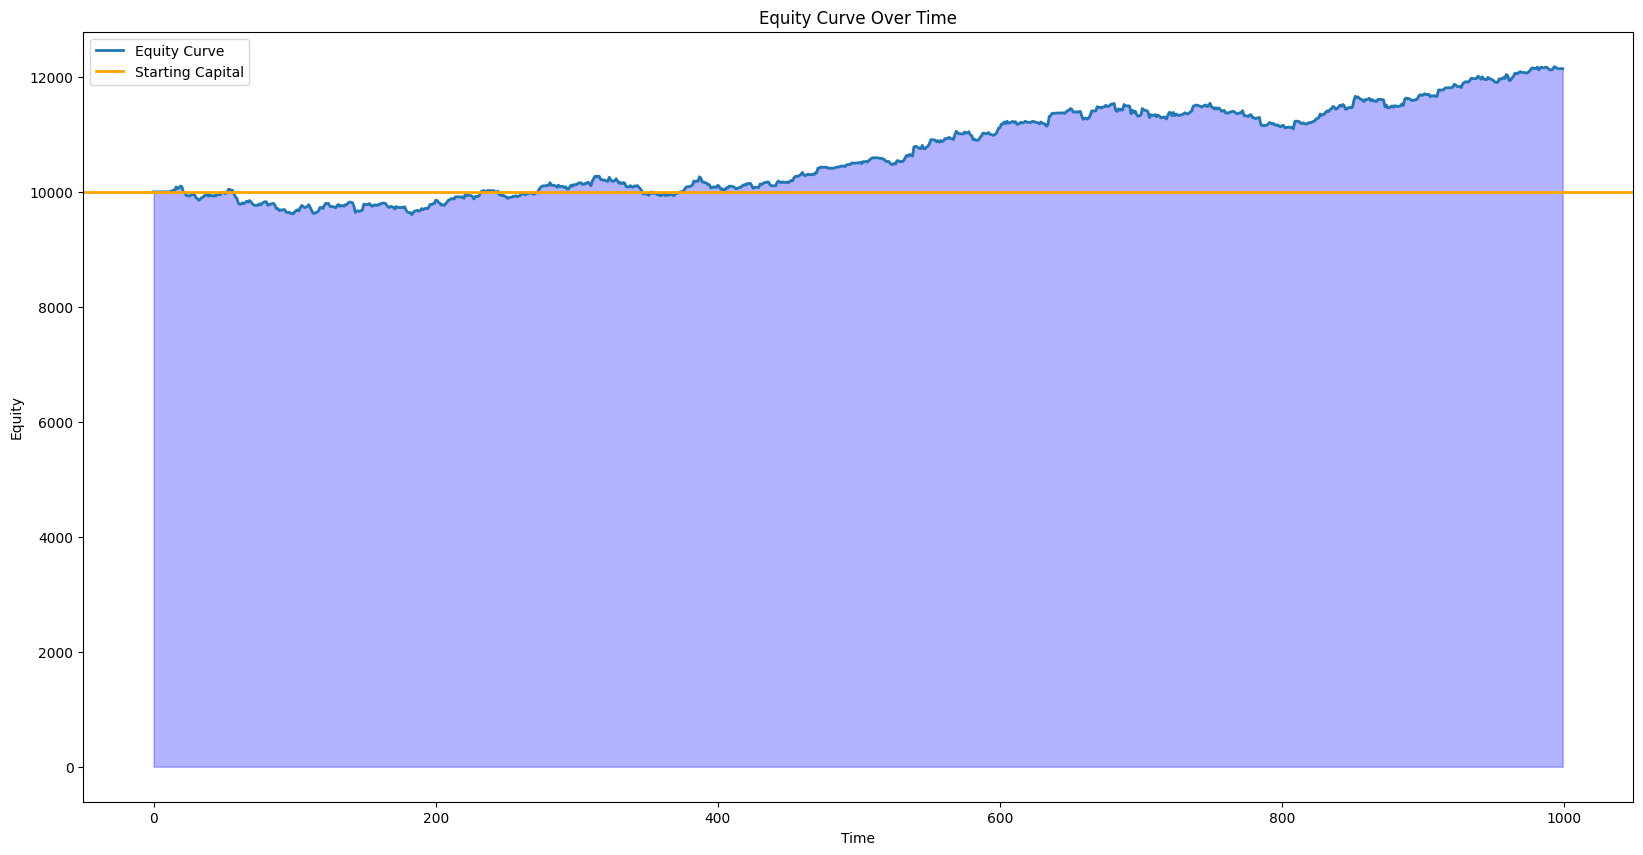

Equity Final [$]: 12141.769300000002


In [82]:

total_money_earned = stats
t = stats.T
print(t["Equity Final [$]"])
equity_curve = [i[0] for i in t._equity_curve.to_numpy()]

equity_curve = equity_curve[:1000]
equity_curve = np.array(equity_curve)


# Limit the number of data points to the first 1000
equity_curve = equity_curve[:1000]

# Plot the equity curve
plt.figure(figsize=(20, 10))
plt.plot(equity_curve, label='Equity Curve', linewidth=2)

# Fill the area between the equity curve and the x-axis
plt.fill_between(range(len(equity_curve)), equity_curve,
                 0, alpha=0.3, color='blue')

# Add labels and legend
plt.axhline(y=10000, color='orange', linestyle='-',
            label='Starting Capital', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curve Over Time')
plt.legend()

plt.show()

# Print the final equity
print(f'Equity Final [$]: {equity_curve[-1]}')


## Results

- Return: 21.4%
- Buy & Hold Return: 10.6%
- Win Rate: 70%


In [83]:
print(stats)

Start                                     0.0
End                                     999.0
Duration                                999.0
Exposure Time [%]                        98.1
Equity Final [$]                   12141.7693
Equity Peak [$]                   12176.83182
Return [%]                          21.417693
Buy & Hold Return [%]               10.624009
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -4.941019
Avg. Drawdown [%]                   -0.632009
Max. Drawdown Duration                  257.0
Avg. Drawdown Duration              17.807692
# Trades                                 53.0
Win Rate [%]                        69.811321
Best Trade [%]                       4.157495
Worst Trade [%]                     -2.494601
Avg. Trade [%]                    